## Subset sampling for GHZ state preparation circuit

**1. Direct Monte Carlo approach**

CPU times: user 18.1 s, sys: 746 ms, total: 18.9 s
Wall time: 17.8 s


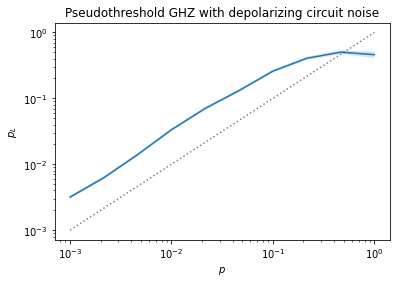

In [59]:
%%time

import pecos as pc
import numpy as np
import matplotlib.pyplot as plt

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))
depolar_gen = pc.error_gens.DepolarGen(model_level='circuit')

def MC(p, n_samples):
    logical_errs = 0
    for _ in range(n_samples):
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, ghz, error_gen=depolar_gen, error_params={'p':p})
        if msmt: 
            logical_errs += 1
    return logical_errs

def MC_gen_p_L(p_phy, sample_range):
    p_L= np.empty_like(p_phy)
    for i, p in enumerate(p_phy):
        n_fails = MC(p, sample_range[i])
        p_L[i] = n_fails / sample_range[i]
    p_L_err = np.sqrt(p_L*(1-p_L)/sample_range)
    return p_L, p_L_err

p_phy = np.logspace(-3, 0, 10) # evenly spaced samples in log space
n_samples = 100
sample_range = np.int_(n_samples / p_phy) # take more samples for lower p_phy
p_L, p_L_err = MC_gen_p_L(p_phy, sample_range)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')
plt.plot(p_phy, p_L)
plt.fill_between(p_phy, p_L-p_L_err, p_L+p_L_err, alpha=0.2)
plt.plot(p_phy, p_phy, 'k:', alpha=0.5)

**2. Subset sampling approach**

CPU times: user 27.2 ms, sys: 6.57 ms, total: 33.8 ms
Wall time: 28.8 ms


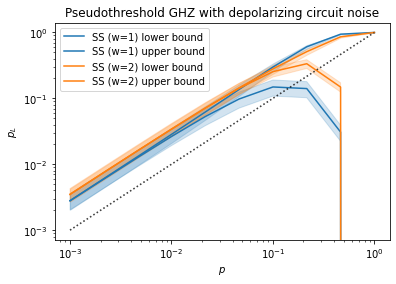

In [2]:
%%time

import itertools
import math
import pecos as pc
import numpy as np
import matplotlib.pyplot as plt

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

two_qb_gates = ['CNOT']
one_qb_gates = ['measure Z', 'H']
one_qb_errs = ['X','Y','Z']
two_qb_errs  = list(itertools.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
two_qb_errs.remove(('I','I')) # remove II as it is not a fault

def subset_sample(ref_circuit, subset_weight, n_samples):
    logical_fails = 0
    for _ in range(n_samples):
        
        # 1. Generate a subset circuit, place random faults at w gates
        subset_circuit = ref_circuit.copy()
        fault_locs = np.random.choice(len(subset_circuit), subset_weight, replace=False)
        for loc in fault_locs:
            for sym, qbs, params in subset_circuit[loc].items():
                if sym in two_qb_gates: 
                    faults = two_qb_errs[np.random.choice(len(two_qb_errs))]
                    for fault, qb in zip(faults, list(*qbs)):
                        if fault != "I": 
                            subset_circuit.insert(loc, ({fault: {qb}}, {}))
                elif sym in one_qb_gates: 
                    fault = np.random.choice(one_qb_errs)
                    subset_circuit.insert(loc, ({fault: qbs}, {}))
                    
        # 2. Simuluate a circuit run with |00..0> and measure in Z
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, subset_circuit)
        
        # 3.Count logical failures
        if msmt: logical_fails += 1
        
    return logical_fails

n_samples = 20 # number of samples per subset
p_phy = np.logspace(-3, 0, 10) # physical error rates
n_gates = len(ghz) # number of gates in reference circuit

def SS_gen_p_L_w(w_max, p_phy, n_samples):
    # Subset logical failure rates: Weight-0 faults have failure rate 0.
    p_L_w = np.array([0] + [subset_sample(ghz,w,n_samples)/n_samples for w in range(1,w_max+1)])

    # Binomial weight: Tot. probability of sampling weight-w circuits from all possible circuits
    A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
    A = np.array([[A_w(p,w,n_gates) for p in p_phy] for w in range(w_max+1)])

    # Overall bounded logical failure rates
    p_L_low = np.sum(A * p_L_w[:,None], axis=0)
    p_L_up = p_L_low + 1 - np.sum(A, axis=0)

    # Subset and overall standard deviations
    e_SS_w = lambda p, n: np.sqrt( (p * (1-p)) / n )
    e_SS = np.sqrt( np.sum((A[1:] * e_SS_w(p_L_w[1:,None], n_samples))**2, axis=0) )
    return p_L_low, p_L_up, e_SS

cols = ['tab:blue', 'tab:orange']
w_max = 2 # gate fault cutoff
for col, w_m in zip(cols,range(1,w_max+1)):
    p_L_low, p_L_up, e_SS = SS_gen_p_L_w(w_m, p_phy, n_samples)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$p$')
    plt.ylabel(r'$p_L$')
    plt.title('Pseudothreshold GHZ with depolarizing circuit noise')
    plt.plot(p_phy, p_L_low, c=col, label="SS (w=%s) lower bound" % w_m)
    plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, alpha=0.2, color=col)
    plt.plot(p_phy, p_L_up, label="SS (w=%s) upper bound" % w_m, c=col)
    plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, alpha=0.2, color=col)
    plt.plot(p_phy, p_phy, 'k:', alpha=0.5)
plt.legend()

**--- Define global functions & variables ---**

In [2]:
import itertools
import math
import pecos as pc
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))
depolar_gen = pc.error_gens.DepolarGen(model_level='circuit')

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})
n_gates = len(ghz)

two_qb_gates = ['CNOT']
one_qb_gates = ['measure Z', 'H']
one_qb_errs = ['X','Y','Z']
two_qb_errs  = list(itertools.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
two_qb_errs.remove(('I','I')) # remove II as it is not a fault

def logical_failure_rate_MC(ref_circuit, error_gen, p_phy, n_samples, max_err=0.0):
    logical_fails = 0
    for _ in range(n_samples):
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, ref_circuit, error_gen=error_gen, error_params={"p":p_phy})
        if msmt: logical_fails += 1
        p_L = logical_fails / n_samples
        p_L_err = np.sqrt(p_L*(1-p_L)/n_samples)
        rel_err = p_L_err / p_L if p_L != 0 else 1 # don't break until we have a non-zero p_L
        if rel_err < max_err: break # only sample until target rel. error of 5%
    return p_L, p_L_err

def subset_failure_rate(ref_circuit, subset_weight, n_samples):
    logical_fails = 0
    for _ in range(n_samples):

        # 1. Generate a subset circuit, place random faults at w gates
        subset_circuit = ref_circuit.copy()
        fault_locs = np.random.choice(len(subset_circuit), subset_weight, replace=False)
        offset = 0
        for loc in fault_locs:
            for sym, qbs, params in subset_circuit[loc].items():
                if sym in two_qb_gates: 
                    faults = two_qb_errs[np.random.choice(len(two_qb_errs))]
                    for fault, qb in zip(faults, list(*qbs)):
                        if fault != "I": 
                            subset_circuit.insert(loc+offset, ({fault: {qb}}, {}))
                            offset += 1
                elif sym in one_qb_gates: 
                    fault = np.random.choice(one_qb_errs)
                    subset_circuit.insert(loc+offset, ({fault: qbs}, {}))
                    offset += 1

        # 2. Simuluate a circuit run with |00..0> and measure in Z
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, subset_circuit)

        # 3.Count logical failures
        if msmt: logical_fails += 1

    return logical_fails / n_samples
    
def logical_failure_rate_SS(ref_circuit, w_max, p_phys, n_samples):

    # generate subset failure rates
    subset_failure_rates = np.array([0] + [subset_failure_rate(ref_circuit, w, n_samples) for w in range(1,w_max+1)])

    # Binomial weight: Tot. probability of sampling weight-w circuits from all possible circuits
    A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
    A = np.array([[A_w(p_phy,w,n_gates) for p_phy in p_phys] for w in range(w_max+1)])

    # Overall bounded logical failure rates
    p_L_low = np.sum(A * subset_failure_rates[:,None], axis=0)
    p_L_up = p_L_low + 1 - np.sum(A, axis=0)

    # Subset and overall standard deviations
    e_SS_w = lambda p, n: np.sqrt( (p * (1-p)) / n )
    e_SS = np.sqrt( np.sum((A[1:] * e_SS_w(subset_failure_rates[1:,None], n_samples))**2, axis=0) )
    return p_L_low, p_L_up, e_SS

logical_failure_rate_MC = partial(logical_failure_rate_MC, ghz.copy(), depolar_gen)
logical_failure_rate_SS = partial(logical_failure_rate_SS, ghz.copy())

**3. Comparison plot**

CPU times: user 18.6 s, sys: 412 ms, total: 19 s
Wall time: 18.5 s


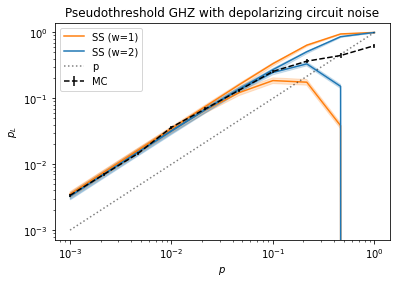

In [309]:
%%time

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')

n_samples = 100 # number of samples per subset
p_phy = np.logspace(-3, 0, 10) # physical error rates

# Plot SS
for col, w_m in zip(['tab:orange', 'tab:blue'],[1,2]):
    p_L_low, p_L_up, e_SS = logical_failure_rate_SS(w_m,p_phy,n_samples)
    plt.plot(p_phy, p_L_low, c=col, label="SS (w=%s)"%w_m)
    plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, color=col, alpha=0.2)
    plt.plot(p_phy, p_L_up, c=col)
    plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, color=col, alpha=0.2)
    
# Plot MC    
p_L_MC, err_MC = [],[]
n_samples = 100
sample_range = np.int_(n_samples / p_phy) # take more samples for lower p_phy
for p, n_samples_MC in zip(p_phy,sample_range):
    p_L, err = logical_failure_rate_MC(p, n_samples_MC)
    p_L_MC.append(p_L)
    err_MC.append(err)
plt.errorbar(p_phy, p_L_MC, fmt='--', c="black", yerr=err_MC, label="MC")

plt.plot(p_phy, p_phy, 'k:', alpha=0.5, label="p")
plt.legend()

**3.1. Behavior for increasing w_max $\rightarrow$ n_gates**

CPU times: user 1min 12s, sys: 1.23 s, total: 1min 14s
Wall time: 1min 12s


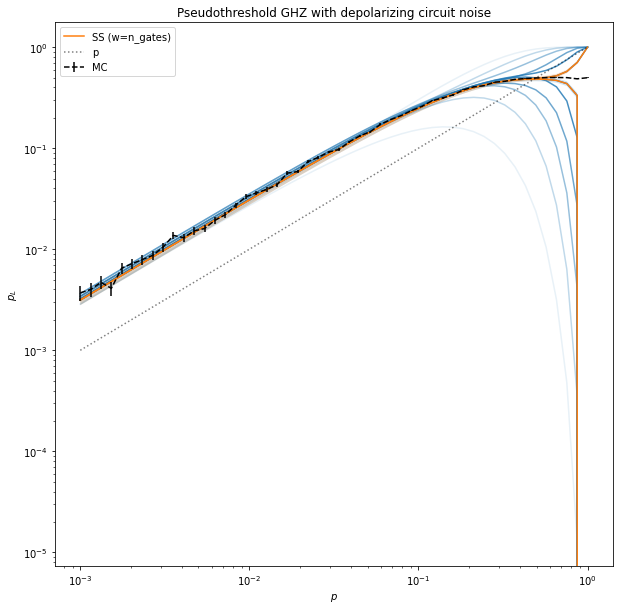

In [307]:
%%time

plt.figure(figsize=(10,10))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')

n_samples = 100 # number of samples per subset
p_phy = np.logspace(-3, 0, 50) # physical error rates
alphas = np.linspace(0.1, 1, n_gates-1) # increase opacity

for alpha, w_m in zip(alphas, range(1,n_gates)):
    p_L_low, p_L_up, e_SS = logical_failure_rate_SS(w_m,p_phy,n_samples)
    plt.plot(p_phy, p_L_low, c='tab:blue', alpha=alpha)
    plt.plot(p_phy, p_L_up, c='tab:blue', alpha=alpha)

plt.plot(p_phy, p_L_low, c='tab:orange', label="SS (w=n_gates)")
plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, alpha=0.2)
plt.plot(p_phy, p_L_up, c='tab:orange')
plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, alpha=0.2)

n_samples_MC = 10_000
# Plot MC    
p_L_MC, err_MC = [],[]
for p in p_phy:
    p_L, err = logical_failure_rate_MC(p, n_samples_MC, max_err=0.01)
    p_L_MC.append(p_L)
    err_MC.append(err)
plt.errorbar(p_phy, p_L_MC, fmt='--', c="black", yerr=err_MC, label="MC")
plt.plot(p_phy, p_phy, 'k:', alpha=0.5, label="p")
plt.legend()

**3.1.1. Bounding behavior for small p**

CPU times: user 1h 21min 56s, sys: 1min 36s, total: 1h 23min 33s
Wall time: 1h 21min 29s


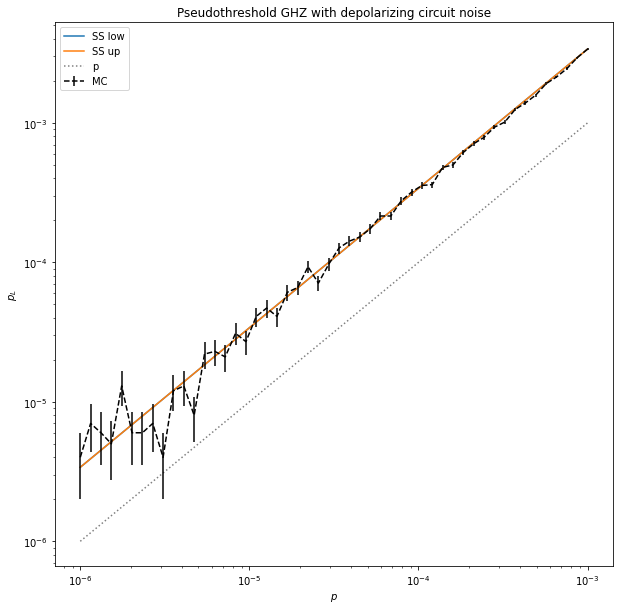

In [36]:
%%time

p_phys = np.logspace(-6, -3, 50) # physical error rates
w_max = 3
n_samples_SS = int(1e3) # Fixed number of samples for subset sampling
n_samples_MC = int(1e6) # Fixed max. number of samples for MC
p_L_low, p_L_up, err_SS = logical_failure_rate_SS(w_max, p_phys, n_samples_SS)

p_L_MC, err_MC = [], []
for p_phy in p_phys:
    p_L, err = logical_failure_rate_MC(p_phy, n_samples_MC, max_err=0.01)
    p_L_MC.append(p_L)
    err_MC.append(err)

plt.figure(figsize=(10,10))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')
plt.plot(p_phys, p_L_low, c='tab:blue', label="SS low")
plt.fill_between(p_phy, p_L_low-err_SS, p_L_low+err_SS, alpha=0.2)
plt.plot(p_phys, p_L_up, c='tab:orange', label="SS up")
plt.fill_between(p_phy, p_L_up-err_SS, p_L_up+err_SS, alpha=0.2)
plt.errorbar(p_phys, p_L_MC, fmt='--', c="black", yerr=err_MC, label="MC")
plt.plot(p_phys, p_phys, 'k:', alpha=0.5, label="p")
plt.legend()

**3.2. Behavior of bound difference $\delta$**<br>
Here we look at how the difference between upper and lower bound **for the same $w_{max}$ bounds** $\delta(p)=p_L^{(up)}-p_L^{(low)}$ changes for varying p and varying sample size. We see that already with very low sample size we get very similar behavior as with high sample sizes. This is also what we theoretically expect, since $\delta$ is independent of sample size: $\delta=1-\sum_w^{w_{max}}{A_w(p)}$.

CPU times: user 27.5 s, sys: 160 ms, total: 27.7 s
Wall time: 27.4 s


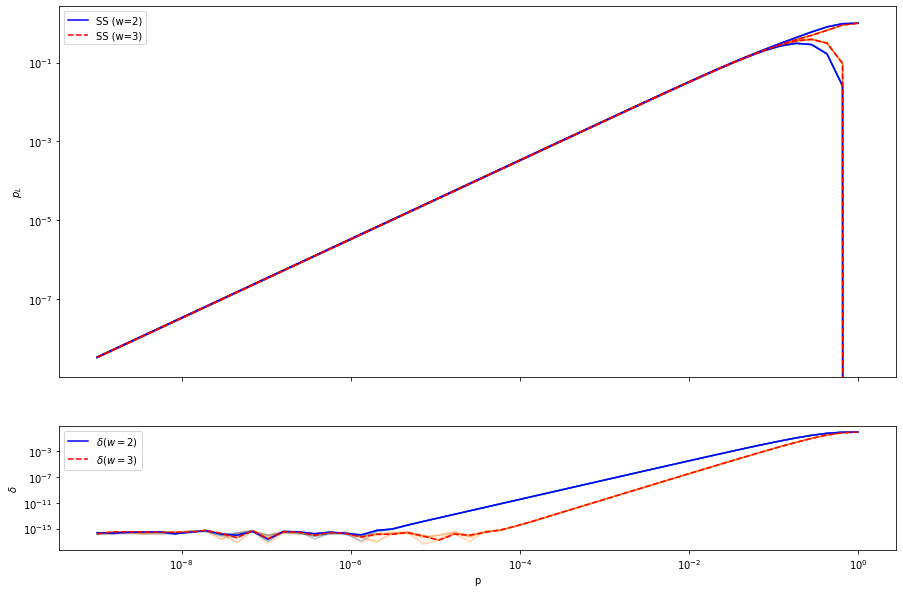

In [36]:
%%time

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,10), gridspec_kw={'height_ratios': [3,1]})

samples = np.arange(10, 10000, 1000)
alphas = [i*0.5/len(samples) for i in range(len(samples))]
p_phy = np.logspace(-9, 0, 50) # physical error rates
# alpha=0.1
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel(r'$p_L$')
ax[1].set_xlabel('p')
ax[1].set_ylabel(r'$\delta$')

for (alpha,n_samples) in zip(alphas,samples):
    p_L_low1, p_L_up1, _ = logical_failure_rate_SS(2,p_phy,n_samples)
    ax[0].plot(p_phy, p_L_low1, c='tab:blue', alpha=alpha)
    ax[0].plot(p_phy, p_L_up1, c='tab:blue', alpha=alpha)
    p_L_low2, p_L_up2, _ = logical_failure_rate_SS(3,p_phy,n_samples)
    ax[0].plot(p_phy, p_L_low2, c='tab:orange', alpha=alpha)
    ax[0].plot(p_phy, p_L_up2, c='tab:orange', alpha=alpha)
    
    diff_low = abs(p_L_up1-p_L_low1)
    diff_up = abs(p_L_up2-p_L_low2)
    ax[1].plot(p_phy, diff_low, c='tab:blue', alpha=alpha)
    ax[1].plot(p_phy, diff_up, c='tab:orange', alpha=alpha)

ax[0].plot(p_phy, p_L_low1, c='blue', label='SS (w=2)')
ax[0].plot(p_phy, p_L_up1, c='blue')
ax[0].plot(p_phy, p_L_low2, '--', c='red', label='SS (w=3)')
ax[0].plot(p_phy, p_L_up2, '--', c='red')
ax[0].legend()

ax[1].plot(p_phy, diff_low, c='blue', label=r'$\delta (w=2)$')
ax[1].plot(p_phy, diff_up, '--', c='red', label=r'$\delta (w=3)$')
ax[1].legend()

It looks like $\delta$ saturates at a value of the order $10^{-15}$ for small $p$. Can we consider $\delta=0$ at this scale?<br>
Looking at the sum of all binomial weights, we would expect it to **always** yield 1..

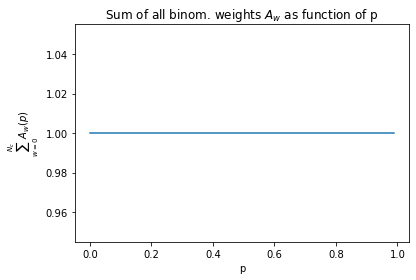

In [146]:
# Note: Have to include all w=0 to 7 terms. 
n_gates = len(ghz)
A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
y = [np.sum([A_w(p,w,n_gates) for w in range(n_gates+1)]) for p in ps]
plt.title("Sum of all binom. weights $A_w$ as function of p")
plt.xlabel("p")
plt.ylabel("$\sum_{w=0}^{N_c}{A_w(p)}$")
plt.plot(ps, y)

.. which is correct, until values of about $10^{-15}$. Thus, subtracting the sum of binomal weights from 1 does not always yield 0. This is only accurate if we consider values in this range to be 0.

Text(0, 0.5, '$\\delta(w=N_c)$')

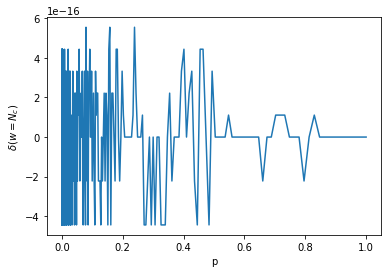

In [155]:
n_gates = len(ghz)
A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
delta = lambda p: 1 - np.sum([A_w(p, w, n_gates) for w in range(n_gates+1)])
x = np.logspace(-9,0,1000)
y = [delta(p) for p in x]
plt.plot(x,y)
plt.xlabel('p')
plt.ylabel(r'$\delta(w=N_c)$');

**3.2.1. Now, we look at how much the $w_{max}=2$ and $w_{max}=3$ bounds converge.**<br>
For this we simply plot $p_L^{(w_{max}=3)}(p) - p_L^{(w_{max}=2)}(p)=A_3(p)p_{3}$, with $p_L^{w_{max}}=\sum_{w}^{w_{max}}{A_w(p)p_w}$ 

CPU times: user 785 ms, sys: 36.1 ms, total: 821 ms
Wall time: 760 ms


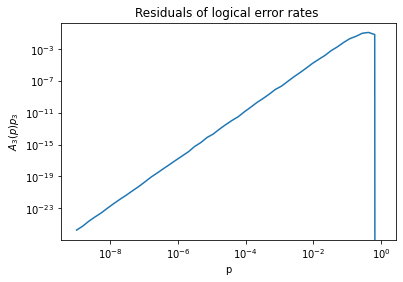

In [5]:
%%time

A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
n_gates = len(ghz) # number of gates in reference circuit
p_phy = np.logspace(-9, 0, 50) # physical error rates
n_samples = 100

diff = []
for p in p_phy:
    diff.append(A_w(p, 3, n_gates) * subset_failure_rate(ghz, 3, n_samples))

plt.title("Residuals of logical error rates ")
plt.xlabel(r'p')
plt.ylabel(r'$A_3(p)p_3$')
plt.yscale('log')
plt.xscale('log')
plt.plot(p_phy, diff)

We can clearly see that the for loger p the two logical error rates for $w_{max}=2$ and $w_{max}=3$ converge more and more.<br>
Also, fixing a particular value (here p=$10^{-7}$) and changing the sample rate again shows that we can choose fairly low sample sizes to achieve similar convergence.

CPU times: user 7.2 s, sys: 91.4 ms, total: 7.29 s
Wall time: 7.17 s


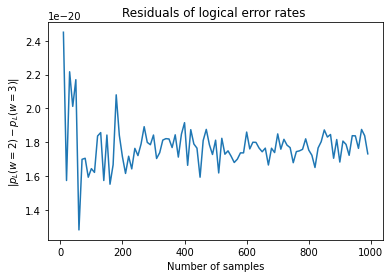

In [8]:
%%time

A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
n_gates = len(ghz) # number of gates in reference circuit
p_phy = 1e-7 # fix physical error rate
samples = np.arange(10, 1000, 10) # increasing no. of samples

diff = []
for n_samples in samples:
    diff.append(A_w(p_phy, 3, n_gates) * subset_failure_rate(ghz, 3, n_samples))

plt.title("Residuals of logical error rates ")
plt.xlabel('Number of samples')
plt.ylabel(r'$|p_L(w=2)-p_L(w=3)|$')
plt.plot(samples, diff)

**3.2.2. Adaptive choice of w_max for targeted $\delta_{max}$ at $p_{max}$**

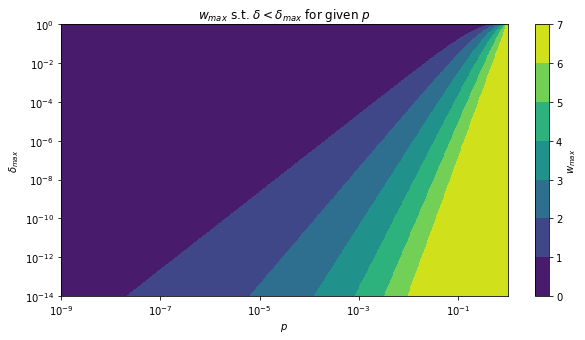

In [216]:
n_gates = len(ghz)
A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)

def adaptive_weight(delta_max, p_max):
    delta = 1
    for w in range(n_gates+1):
        delta -= A_w(p_max, w, n_gates)
        if delta < delta_max: break
    return w

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)
Z = np.array([[adaptive_weight(delta, p_max) for p_max in ps] for delta in ds])

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');

**4. Multi-parameter noise model**

In [31]:
### Under construction ###

import itertools
import math
import pecos as pc
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))
depolar_gen = pc.error_gens.DepolarGen(model_level='circuit')

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})
n_gates = len(ghz)
n_qbs = 5

two_qb_gates = ['CNOT']
one_qb_gates = ['measure Z', 'H']
one_qb_errs = ['X','Y','Z']
two_qb_errs  = list(itertools.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
two_qb_errs.remove(('I','I')) # remove II as it is not a fault

all_gate_locs = list(range(n_gates)) 
one_qb_gate_locs = [i for i, (sym, _, _) in enumerate(ghz.items()) if sym in one_qb_gates]
two_qb_gate_locs = [i for i, (sym, _, _) in enumerate(ghz.items()) if sym in two_qb_gates]

def apply_faults_at_locs(circuit, fault_locs):
    err_circuit = pc.error_gens.ErrorCircuits()
    for loc in fault_locs:
        for sym, qbs, params in circuit[loc].items():
            if sym in two_qb_gates: 
                faults = two_qb_errs[np.random.choice(len(two_qb_errs))]
                for fault, qb in zip(faults, list(*qbs)):
                    if fault != "I": 
                        err_circuit.add_circuits(loc, after_faults=pc.circuits.QuantumCircuit([{fault: {qb}}]))
            elif sym in one_qb_gates: 
                fault = np.random.choice(one_qb_errs)
                err_circuit.add_circuits(loc, after_faults=pc.circuits.QuantumCircuit([{fault: qbs}]))
    return err_circuit

# def get_fault_locs(circuit, err_params):
#     params = err_params.keys()

#     def random_indices(indices, n=None, p=None):
#         if n: return list(np.random.choice(indices, n, replace=False))
#         elif p: return [i for i in indices if np.random.random() < p]
#         else: return []

#     if 'w' in params: return random_indices(all_gate_locs, n=err_params['w'])
#     elif 'p' in params: return random_indices(all_gate_locs, p=err_params['p'])
#     elif 'p1' in params and 'p2' in pareams:
#         return random_indices(one_qb_gate_locs, p=err_params['p1']) + random_indices(two_qb_gate_locs, p=err_params['p2'])
#     elif 's' in params and 't' in params:
#         return random_indices(one_qb_gate_locs, n=err_params['s']) + random_indices(two_qb_gate_locs, n=err_params['t'])
#     else: raise "Unknown error params: %s" % err_params

# def gen_error_circuit(circuit, err_params):
#     locs = get_fault_locs(circuit, err_params)
#     return apply_faults_at_locs(circuit, locs)

# def sample(circuit, err_circuit):
#     sim = pc.simulators.SparseSim(n_qbs)
#     msmt, _ = circ_runner.run(sim, circuit, error_circuits=err_circuit)
#     if msmt: return 1
#     else: return 0

from functools import partial

def sample_p_L(circuit, err_ids_fn, n_samples):
    logical_fails = 0
    for _ in range(n_samples):
        err_circuit = apply_faults_at_locs(circuit, err_ids_fn())
        sim = pc.simulators.SparseSim(n_qbs)
        msmt, _ = circ_runner.run(sim, circuit, error_circuits=err_circuit)
        if msmt: logical_fails += 1
    return logical_fails / n_samples

def naive_sampler(circuit, n_samples, err_params):
    params = err_params.keys()
    if "p" in params: 
        random_ids = lambda p, ids: [i for i in ids if np.random.random() < p] 
        ids_fn = partial(random_ids, err_params["p"], all_gate_locs)
    elif "p1" in params and "p2" in params:
        random_ids = lambda p1, p2, ids1, ids2: [i for i in ids1 if np.random.random() < p1] + [i for i in ids2 if np.random.random() < p2] 
        ids_fn = partial(random_ids, err_params["p1"], err_params["p2"], one_qb_gate_locs, two_qb_gate_locs)
    else:
        raise "Unknown parameter: " % err_params
    p_L = sample_p_L(circuit, ids_fn, n_samples)
    std = np.sqrt( p_L * (1-p_L) / n_samples)
    return p_L, std

def subset_sampler(circuit, n_samples, err_params):
    A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
    n_gates = len(circuit)
    params = err_params.keys()
    if "p" in params and "w" in params:
        random_ids = lambda w, ids: list(np.random.choice(ids, w, replace=False))
        A = np.array([A_w(err_params["p"], w, n_gates) for w in range(err_params["w"]+1)])
        p_L = np.zeros_like(A)
        for w in range(1, err_params["w"]+1):
            ids_fn = partial(random_ids, w, all_gate_locs)
            p_L[w] = sample_p_L(circuit, ids_fn, n_samples)
        p_L_low = np.sum( np.product((A, p_L), axis=0) )
        p_L_up = p_L_low + 1 - np.sum(A)
        std = np.sqrt( np.sum( A[1:] * (err_params["p"] * (1-err_params["p"]) / n_samples) , axis=0) )
        return p_L_low, p_L_up, std
        
    elif "p1" in params and "p2" in params and "w1" in params and "w2" in params:
        pass
    else:
        raise "Unknown parameter: " % err_params


def subset_probabilities(ps, ws, n_gates):
    assert len(ps) == len(ws)
    A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
    A = np.zeros((len(ps), np.max(ws)))
    for i, p in enumerate(ps):
        for j, w in enumerate(ws):
            A[i,j] = A_w(p, w, n_gates)
    return A
# def naive_sampler(ref_circuit, n_samples, err_params, std_target=0.0):
#     logical_fails = 0
#     for _ in range(n_samples):
#         err_circuit = gen_error_circuit(ref_circuit, err_params)
#         logical_fails += sample(ref_circuit, err_circuit)
#         p_L = logical_fails / n_samples
#         std = np.sqrt(p_L * (1 - p_L) / n_samples)
#         rel_std = std / p_L if p_L != 0 else 1
#         if rel_std < std_target: break
#     return p_L, std

# def subset_sampler(ref_circuit, n_samples, err_params):
#     # A_s_t = lambda p_s,p_t,s,t,N_s,N_t: math.comb(N_s,s) * p_s**(s) * (1-p_s)**(N_s-s) * math.comb(N_t,t) * p_t**(t) * (1-p_t)**(N_t-t)
#     # A = [[A_s_t() ]
#     p_L_acc = 0
#     for s in range(1, err_params['s']+1):
#         for t in range(1, err_params['t']+1):
#             logical_fails = 0 
#             for _ in range(n_samples):
#                 err_circuit = gen_error_circuit(ref_circuit, {'s':s, 't':t})
#                 logical_fails += sample(ref_circuit, err_circuit)
#             p_L = logical_fails / n_samples
            

# msmt, _ = circ_runner.run(sim, ghz, error_circuits=err_circ)
# circ_runner.run()

# err_params = {'p':0.1, 'w':1}
# subset_sampler(ghz, 100, err_params)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
p_phy = np.logspace(-3, 0, 10) # physical error rates    
p_L_MC, err_MC = [],[]
n_samples = 1000
for p in p_phy:
    p_L, err = naive_sampler(ghz, n_samples, err_params={'p':p})
    p_L_MC.append(p_L)
    err_MC.append(err)
plt.errorbar(p_phy, p_L_MC, fmt='--', c="black", yerr=err_MC, label="MC")
plt.plot(p_phy, p_phy, 'k:', alpha=0.5, label="p")
plt.legend()



(0.14136330600000002, 0.2910577059999999, 0.018297754780300234)